In [1]:
# Load Required Libraries
# -----------------------

library(knitr)
library(labelled)     # For handling variable labels
knitr::opts_chunk$set(erro= F, warning= F, message=F, fig.width = 8, collapse = TRUE)
library(readxl) # import xlsx data
library(gglasso) # load gglasso library
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(pROC)))

### Import Data

In [2]:
# Import data from Excel file
## 1. Import baseline & psychosocial data
### Define your desired column names
desired_col_names <- c('UserName','IBDZL','Center','NumberOfMeasurements',
                       'NumberOfMeasurementsWithCalproWithinRange',
                       'NumberofMeasurementsMeetingCalpro<150Pain>2','PercCriteria1',
                       'PercCriteria2',
                       'NumberofMeasurementsMeetingCalpro<150Pain<3','PercCriteria',
                       'GroupsCalpro<150Pain>2','GroupNewReversed','Gender','DateofBirth',
                       'AgeAtCohortEntry','DiseaseEntity','DiagDateFinal','AgeatDiag',
                       'DiseaseDurationAtCohortEntry','DiseaseDurationCategory','Montreal_A_diag',
                       'Montreal_L_diag_final','Montreal_B_diag_final','Montreal_P_diag_final',
                       'Montreal_P_ever_manualfinal','Montreal_U_diag_final','Montreal_U_ever_final',
                       'Montreal_E_diag_Final','Montreal_E_ever_final',
                       'IBDsurgeryHistory_manualfinal','IBDsurgery_resection_manualfinal',
                       'CCI_adjusted','BMI_baseline','BMI_category',
                       'CurrentStoma','Stoma_history','Smoking_final','Family_IBD_final',
                       'MIAH_pain_median','MIAH_pain_firstvalue','MIAH_pain_mean',
                       'Stress_median','Stress_firstvalue','Stress_mean',
                       'Depression_median_1','Depression_firstvalue_1','Depression_mean_1',
                       'Depression_median_2','Depression_firstvalue_2','Depression_mean_2',
                       'Anxious_median_1','Anxious_firstvalue_1','Anxious_mean_1',
                       'Anxious_median_2','Anxious_firstvalue_2','Anxious_mean_2',
                       'Fatigue_median_1','Fatigue_firstvalue_1','Fatigue_mean_1',
                       'Fatigue_median_2','Fatigue_firstvalue_2','Fatigue_mean_2',
                       'LifeEvents_incase')

## 1. Import data using the defined col names
data <- read_excel("/kaggle/input/database/data.xlsx", sheet = 1,col_names = desired_col_names,skip = 1)#Baseline

## 2. Import Medication Data
dataMed <- read_excel("/kaggle/input/database/PRIQ_Masterfile_Medication_MUMCZDL_0812proj.xlsx", sheet = 1)#Medication

## 3. Import lifestyle Data
dataLifeStyle <- read_excel("/kaggle/input/database/Physical Exercise.xlsx", sheet = 1)#lifestyle

print(paste0('Data source import complete'))

[1] "Data source import complete"


In [3]:
table(data$GroupNewReversed)


  0   1 
231 198 

## I.2 Prepare BaseLine &  psychosocial data

Let's start with the baseline data, here are the explanatory variables in the Baseline:





| Label                                   | Variable Name                                         | Measurement Scale | # of Levels | Categories                               |
|-----------------------------------------|------------------------------------------------------|-------------------|-------------|------------------------------------------|
| Gender                                  | Gender                                               | Nominal           | 2           | Female, Male                             |
| AgeAtCohortEntry                       | Age at baseline (years)                             | Interval          |             |                                          |
| DiseaseEntity                           | Phenotype                                           | Nominal           | 2           | CD, UC                                   |
| DiseaseDurationAtCohortEntry           | Disease duration                                    | Interval          |             |                                          |
| DiseaseDurationCategory                 | Disease duration                                    | Nominal           | 2           |                                          |
| AgeatDiag                               | Age at diagnosis                                    | Ratio             |             |                                          |
| Montreal_A_diag                         | Montreal at diagnosis: Age                          | Nominal           | 3           | <16, 16-40, >40                          |
| Montreal_L_Diag                         | Montreal at diagnosis: Disease location (CD)       | Nominal           | 3           | ileal, colonic, ileocolonic             |
| Montreal_B_Diag                         | Montreal at diagnosis: Disease behavior (CD)       | Nominal           | 3           | inflammatory, stricturing, penetrating   |
| Montreal_P_diag_final                   | Montreal at diagnosis: Perianal disease (CD)      | Nominal           | 3           | ileal, colonic, ileocolonic             |
| Montreal_U_diag_final                   | Montreal at diagnosis: Upper GI disease (CD)      | Nominal           | 2           | No, Yes                                  |
| Montreal_E_diag_Final                   | Montreal at diagnosis: Disease extent (UC)         | Nominal           | 3           | proctitis, left-sided colitis, extensive/pancolitis |
| Montreal_P_ever_manualfinal             | Montreal: Perianal disease maximum (CD)            | Nominal           | 2           | No, Yes                                  |
| Montreal_U_ever_final                   | Montreal: Upper GI disease maximum (CD)            | Nominal           | 2           | No, Yes                                  |
| Montreal_E_ever_final                   | Montreal: Disease extent UC maximum                 | Nominal           | 3           | proctitis, left-sided colitis, extensive/pancolitis |
| IBDsurgeryHistory_manualfinal            | History of IBD surgery                              | Nominal           | 2           | No, Yes                                  |
| IBDsurgery_resection_manualfinal        | IBD surgery resection                               | Nominal           | 2           | No, Yes                                  |
| Family_IBD_final                        | Family history IB                                   | Nominal           | 2           | No, Yes                                  |
| Smoking_final                           | Current smoking at baseline                         | Nominal           | 2           | No, Yes                                  |
| CurrentStoma                           | Current stoma at baseline                           | Nominal           | 2           | No, Yes                                  |
| Stoma_history                          | History of stoma at baseline                        | Nominal           | 2           | No, Yes                                  |
| BMI_baseline                           | BMI at baseline                                     | Ratio             |             |                                          |
| BMI_category                           | BMI category at baseline                            | Nominal           | 3           | 18.5-25.0, 25.0-30.0, ≥30.0            |
| CCI_adjusted                           |- Adjusted rate ratios for Crohn’s disease-related surgery. CCI   |- Nominal      |- 3         |- 0, 1-2, >2                              |

Medication at baseline 

In [4]:
data$MIAH_pain <-  data$MIAH_pain_mean  #data$MIAH_pain_median + data$MIAH_pain_firstvalue +
data$Stress <- data$Stress_mean # data$Stress_median + data$Stress_firstvalue + 
data$Depression1 <- data$Depression_mean_1 # data$Depression_median_1 + data$Depression_firstvalue_1 + 
data$Depression2 <- data$Depression_mean_2 # data$Depression_median_2 + data$Depression_firstvalue_2 + 
data$Anxious1 <- data$Anxious_mean_1# data$Anxious_median_1 + data$Anxious_firstvalue_1 + 
data$Anxious2 <- data$Anxious_mean_2 # data$Anxious_median_2 + data$Anxious_firstvalue_2 + 
data$Fatigue1 <- data$Fatigue_mean_1 # data$Fatigue_median_1 + data$Fatigue_firstvalue_1 + 
data$Fatigue2 <- data$Fatigue_mean_2 # data$Fatigue_median_2 + data$Fatigue_firstvalue_2 + 

In [5]:
data <- data %>%
  select(-c(2:11, 39:62,DateofBirth,DiagDateFinal))  # Drop first 11 variables: 'IBDZL''Center''NumberOfMeasurements''NumberOfMeasurementsWithCalproWithinRange''NumberofMeasurementsMeetingCalpro<150Pain>2''PercCriteria...7''PercCriteria...8''NumberofMeasurementsMeetingCalpro<150Pain<3''PercCriteria...10''GroupsCalpro<150Pain>2'

In [6]:
# Preparing data 
# Convert response variables to factor  
data$GroupNewReversed <- factor(data$GroupNewReversed, labels= c("no flares", "flares"))
data$Gender <- factor(data$Gender, labels= c("Female", "Male"))  
data$DiseaseEntity <- factor(data$DiseaseEntity, labels= c("CD", "UC"))
data$DiseaseDurationCategory <- factor(data$DiseaseDurationCategory)#, labels= 3 cats c())
data$IBDsurgeryHistory_manualfinal <- factor(data$IBDsurgeryHistory_manualfinal, labels= c("No", "Yes"))
data$IBDsurgery_resection_manualfinal <- factor(data$IBDsurgery_resection_manualfinal, labels= c("No", "Yes"))
data$CCI_adjusted <- factor(data$CCI_adjusted, labels= c("0", "1-2", ">2"))
data$BMI_category <- factor(data$BMI_category, labels= c("18.5-25.0", "25.0-30.0","≥30.0"))
data$CurrentStoma <- factor(data$CurrentStoma, labels= c("No", "Yes"))
data$Stoma_history <- factor(data$Stoma_history, labels= c("No", "Yes"))
data$Family_IBD_final <- factor(data$Family_IBD_final)#, labels=3 cats c())
data$Montreal_A_diag <- factor(data$Montreal_A_diag, labels= c("<16", "16-40",">40"))
data$Montreal_L_diag_final   <- factor(data$Montreal_L_diag_final, labels= c("ileal","colonic","ileocolonic","NA"))# "upper GI"
data$Montreal_B_diag_final  <- factor(data$Montreal_B_diag_final, labels= c("inflammatory","stricturing", "penetrating","NA"))
data$Montreal_P_diag_final   <- factor(data$Montreal_P_diag_final, labels= c("No", "Yes","NA"))
data$Montreal_P_ever_manualfinal  <- factor(data$Montreal_P_ever_manualfinal, labels= c("No", "Yes","NA"))
data$Montreal_U_diag_final  <- factor(data$Montreal_U_diag_final, labels= c("No", "Yes","NA"))
data$Montreal_U_ever_final  <- factor(data$Montreal_U_ever_final, labels= c("No", "Yes","NA"))
data$Montreal_E_diag_Final <- factor(data$Montreal_E_diag_Final, labels= c("proctitis", "left-sided colitis","extensive/pancolitis","NA"))
data$Montreal_E_ever_final <- factor(data$Montreal_E_ever_final, labels= c("proctitis", "left-sided colitis","extensive/pancolitis","NA"))

## I.3 Prepare Medicament data

In [7]:
dataMed <- dataMed %>% select(c(Username, Medicament))
dataMed$value <-  1  # Create a column with 1s indicating medication taken

# reshaping the data : Transform the data from long to wide format
wide_dataMed <- dataMed %>%
  pivot_wider(names_from = Medicament,
              values_from = value, values_fill = list(value = 0),
              values_fn = list(value = sum))%>%
  rename(UserName = Username)          # Rename the variable



# Convert MEDICATION columns to factors with labels No, Yes, and NA
wide_dataMed[c(-1)] <- wide_dataMed[c(-1)] %>%
  mutate(across(everything(), 
                 ~ factor(.,
                          levels= c(0,1, "NA"),  # Add "NA" as a level
                           labels = c("No", "Yes", "NA" ) ,
                         exclude = NULL)))  # Include NA as a level
wide_dataMed <- wide_dataMed %>%
  select(UserName,Adalimumab, `Budesonide`, `Geen medicatie`, Infliximab, 
         Mercaptopurine, Mesalazine, Prednison, Tioguanine,
         Ustekinumab, Vedolizumab)

## I.4 Prepare lifestyle Data

In [8]:
# Smoking Status
data$Smoking_final <- factor(data$Smoking_final, labels= c("Never", "Current","Former"))

# Reorder variables in dataLifeStyle, moving Smoking_final to the end
data <- data %>%
  select(-Smoking_final, everything(), Smoking_final)

# Life Events
data$LifeEvents_inCase  <- factor(data$LifeEvents_incase, labels= c("No", "Yes"))
data$LifeEvents_incase  <- NULL

# Physical Exercise
## Recode 'Physical Exercise' to factor with two levels
data$PhysicalExercise <- recode(dataLifeStyle$`Physical Exercise`,
                                            `0` = "none",   # 0 becomes "none"
                                            `1` = "none",  # 1 becomes "none"
                                            `2` = "none",  # 2 becomes "none"
                                            `3` = "none",  # 3 becomes "none"
                                            `4` = "none",  # 4 becomes "none"
                                            `5` = "very active")  # 5 becomes "very active"

## Convert to factor
data$PhysicalExercise <- as.factor(data$PhysicalExercise)



### I.5 Join-Datasets based on UserName

In [9]:
joined_data <- data %>%
  left_join(wide_dataMed, by = "UserName") %>% # Use inner_join to combine by UserName
    rename(Flares= GroupNewReversed)%>%
    mutate(Flares = recode(Flares,  "no flares"="No", "flares"="Yes")) 
#joined_data <- na.omit(joined_data)

In [10]:
# Set variable labels
joined_data <- joined_data %>%
  set_variable_labels(
     Flares=  "Flares",
    BMI_category   = "BMI at baseline",        
CCI_adjusted =       	"CCI Adjusted",
CurrentStoma  =   "Current stoma at baseline",
DiseaseDurationCategory  =   "Disease duration",
DiseaseEntity  =   "Phenotype",
Family_IBD_final  =   "Family history IB",
Gender  =   "Gender",
IBDsurgeryHistory_manualfinal =   "History of IBD surgery",
IBDsurgery_resection_manualfinal =   "IBD surgery resection",
Montreal_A_diag =   "Montreal at diagnosis: Age",
Montreal_B_diag_final  =   "Montreal at diagnosis: Disease behavior (CD)",
Montreal_E_diag_Final  =    	"Montreal at diagnosis: Disease extent (UC)",
Montreal_E_ever_final   =   "Montreal: Disease extent UC maximum",
Montreal_L_diag_final   =  "Montreal at diagnosis: Disease location (CD)", 
Montreal_P_diag_final =   "Montreal at diagnosis: Perianal disease (CD)",
Montreal_P_ever_manualfinal  = "Montreal: Perianal disease maximum (CD)"  ,
Montreal_U_diag_final  =   "Montreal at diagnosis:Upper GI disease (CD)",
Montreal_U_ever_final  =   "Montreal: Upper GI disease maximum (CD)",
Stoma_history   =   "History of stoma",
      AgeAtCohortEntry = "Age at baseline",
      AgeatDiag = "Age at diagnosis",
      DiseaseDurationAtCohortEntry = "Disease duration at baseline",
      BMI_baseline = "BMI at baseline",
      LifeEvents_inCase = "Life Events",
      Smoking_final  =   "Current smoking at baseline",
    PhysicalExercise = "Physical Exercise"
  )


#  II. Statistics


### II.1 DV Statistics

The output table indicates that among the participants, 225 (52.4%) experienced no flares, while 204 (**47.6%**) **reported experiencing flares**.

In [11]:
# Compute frequency and percentage of GroupNewReversed
group_summary <- joined_data %>%
  group_by(Flares) %>%
  summarise(Frequency = n(),
            Percentage = (n() / nrow(joined_data)) * 100) %>%
  ungroup()

# Format the table as a Markdown table
markdown_table <- group_summary %>%
  mutate(Percentage = round(Percentage, 1)) %>%  # Round percentage to one decimal place
  rename(
         `Frequency (N)` = Frequency,
         `Percentage (%)` = Percentage) %>%
  kable(format = "markdown", align = "c")

# Display the Markdown table
markdown_table




| Flares | Frequency (N) | Percentage (%) |
|:------:|:-------------:|:--------------:|
|   No   |      231      |      53.8      |
|  Yes   |      198      |      46.2      |


## II.1 Baseline Statistics

Baseline: columns 2 to 26

In [12]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2:25)] %>% 
  select(where(is.factor))


# Define a mapping of variable names to labels

         label_mapping <- c(
BMI_category   = "BMI at baseline",        
CCI_adjusted =       	"CCI Adjusted ",
CurrentStoma  =   "Current stoma at baseline",
DiseaseDurationCategory  =   "Disease duration",
DiseaseEntity  =   "Phenotype",
Family_IBD_final  =   "Family history IB",
Gender  =   "Gender",
IBDsurgeryHistory_manualfinal =   "History of IBD surgery",
IBDsurgery_resection_manualfinal =   "IBD surgery resection",
Montreal_A_diag =   "Montreal at diagnosis: Age",
Montreal_B_diag_final  =   "Montreal at diagnosis: Disease behavior (CD)",
Montreal_E_diag_Final  =    	"Montreal at diagnosis: Disease extent (UC)",
Montreal_E_ever_final   =   "Montreal: Disease extent UC maximum",
Montreal_L_diag_final   =  "Montreal at diagnosis: Disease location (CD)", 
Montreal_P_diag_final =   "Montreal at diagnosis: Perianal disease (CD)",
Montreal_P_ever_manualfinal  = "Montreal: Perianal disease maximum (CD)"  ,
Montreal_U_diag_final  =   "Montreal at diagnosis:Upper GI disease (CD)",
Montreal_U_ever_final  =   "Montreal: Upper GI disease maximum (CD)",
Stoma_history   =   "History of stoma"
)


# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage


# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the final sorted table with p-values
print(kable(apa_table, format = "markdown", align = "c"))



|              Factor              |       Category       | Flares | Freq | Pct |
|:--------------------------------:|:--------------------:|:------:|:----:|:---:|
|           BMI_category           |      18.5-25.0       |   No   |  4   | 67  |
|           BMI_category           |      18.5-25.0       |  Yes   |  2   | 33  |
|           BMI_category           |      25.0-30.0       |   No   | 109  | 60  |
|           BMI_category           |      25.0-30.0       |  Yes   |  74  | 40  |
|           BMI_category           |        ≥30.0         |   No   | 118  | 49  |
|           BMI_category           |        ≥30.0         |  Yes   | 122  | 51  |
|           CCI_adjusted           |          0           |   No   |  95  | 52  |
|           CCI_adjusted           |          0           |  Yes   |  89  | 48  |
|           CCI_adjusted           |         1-2          |   No   |  94  | 55  |
|           CCI_adjusted           |         1-2          |  Yes   |  78  | 45  |
|           CC

### **Compute p-values**

In [13]:
# Create a function to calculate p-values for categorical variables
calculate_pvalue <- function(data, variable) {
  # Create a contingency table
  cont_table <- table(data[[variable]], data$Flares)
  
  # Perform chi-square test (or Fisher's exact test if sample size is small)
  if (any(chisq.test(cont_table)$expected < 5)) {
    test_result <- fisher.test(cont_table, simulate.p = TRUE, B = 10000)
  } else {
    test_result <- chisq.test(cont_table)
  }
  
  return(round(test_result$p.value,5))
}

# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
pvalues_df <- p_value_df%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

pvalues_df
 

Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”


,Factor,p_value
,<chr>,<dbl>
Gender,Gender,0.00000
DiseaseDurationCategory,Disease duration,0.00087
Montreal_L_diag_final,Montreal at diagnosis: Disease location (CD),0.02831
BMI_category,BMI at baseline,0.09049
DiseaseEntity,Phenotype,0.09330
Montreal_E_diag_Final,Montreal at diagnosis: Disease extent (UC),0.09878
Montreal_P_ever_manualfinal,Montreal: Perianal disease maximum (CD),0.14332
Montreal_U_diag_final,Montreal at diagnosis:Upper GI disease (CD),0.17492
Montreal_U_ever_final,Montreal: Upper GI disease maximum (CD),0.17577


In [14]:

#  Add p-values to the table
final_apa_table_with_pvalues <- apa_table %>%
  left_join(p_value_df %>% select(Factor, p_value), by = "Factor") %>%
  arrange(Factor, Category, Flares)

# Sort by p-values
# get the ordered list of variables from p_value_df
ordered_Factors <- factor(p_value_df$Factor, 
                           levels = p_value_df$Factor)

# Create a factor with levels in the desired order for sorting
final_apa_table_with_pvalues$Factor <- factor(final_apa_table_with_pvalues$Factor,
                             levels = levels(ordered_Factors))

# Sort the apa_table based on this p-values
final_apa_table_with_pvalues <- final_apa_table_with_pvalues %>%
  arrange(Factor)%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

# Print the final sorted table with p-values
print(kable(final_apa_table_with_pvalues, format = "markdown", align = "c"))



|                    Factor                    |       Category       | Flares | Freq | Pct | p_value |
|:--------------------------------------------:|:--------------------:|:------:|:----:|:---:|:-------:|
|                    Gender                    |        Female        |   No   | 125  | 69  | 0.00000 |
|                    Gender                    |        Female        |  Yes   |  57  | 31  | 0.00000 |
|                    Gender                    |         Male         |   No   | 106  | 43  | 0.00000 |
|                    Gender                    |         Male         |  Yes   | 141  | 57  | 0.00000 |
|               Disease duration               |          0           |   No   |  97  | 46  | 0.00087 |
|               Disease duration               |          0           |  Yes   | 116  | 54  | 0.00087 |
|               Disease duration               |          1           |   No   | 134  | 62  | 0.00087 |
|               Disease duration               |          1   

In [15]:
# Select quantitative variables from joined_data
quantitative_data <- joined_data[c(2:25)] %>%
  select(where(is.numeric), Flares) # Keep only numeric columns and GroupNewReversed

# Calculate t-test p-values for all quantitative variables
calculate_ttest_pvalue <- function(data, variable) {
  # Split the data into two groups based on Flares
  group1 <- data[data$Flares == levels(data$Flares)[1], variable]
  group2 <- data[data$Flares == levels(data$Flares)[2], variable]
  
  # Check if there's enough data in both groups
  if (length(group1) > 0 && length(group2) > 0) {
    # Perform t-test
    test_result <- t.test(group1, group2)
    return(round(test_result$p.value, 5))
  } else {
    return(NA)
  }
}

                   
# Compute mean and standard deviation for each quantitative variable by flare status
summary_stats <- quantitative_data %>%
  group_by(Flares) %>%
  summarise(across(where(is.numeric), 
                   ~ paste0(round(mean(., na.rm = TRUE), 2), " (", round(sd(., na.rm = TRUE), 2), ")"),
                   .names = "{.col}")) %>%
  ungroup()

# Calculate p-values for each variable
continuous_variable_names <- names(quantitative_data)[names(quantitative_data) != "Flares"]
t_pvalues <- sapply(continuous_variable_names, function(var) calculate_ttest_pvalue(quantitative_data, var))
p_value_df <- data.frame(Variable = continuous_variable_names, p_value = t_pvalues)



# Add p-values as a new row

# Convert the Flares column to character first
summary_stats$Flares <- as.character(summary_stats$Flares)
p_values_row <- c("pvalues", p_value_df$p_value)
names(p_values_row) <- c("Flares", continuous_variable_names)
apa_table <- rbind(summary_stats, p_values_row)


# Format the summary statistics for APA style
# Replace R variable names with labels in the table
for (var in names(apa_table)[-1]) {  # Exclude 'Flares'
  label <- var_label(joined_data[[var]])  # Get label for the variable
  new_name <- paste(label, "(Mean, SD)", sep = " ")
  colnames(apa_table)[colnames(apa_table) == var] <- new_name
}

## Transpose the table
apa_table_transposed <- as.data.frame(t(apa_table))
# Set the first row as column names
colnames(apa_table_transposed) <- apa_table_transposed[1, ]
apa_table_transposed <- apa_table_transposed[-1, ]


apa_table_transposed <- apa_table_transposed %>%
                    arrange(pvalues)

# Print the transposed APA-style table
print(kable(apa_table_transposed, format = "markdown", align = "c"))



|                                        |      No       |      Yes      | pvalues |
|:---------------------------------------|:-------------:|:-------------:|:-------:|
|Disease duration at baseline (Mean, SD) | 14.06 (11.03) | 11.49 (10.41) | 0.01347 |
|Age at baseline (Mean, SD)              | 50.53 (14.59) | 47.12 (13.97) | 0.01415 |
|BMI at baseline (Mean, SD)              | 25.79 (3.91)  | 26.71 (4.73)  | 0.0306  |
|Age at diagnosis (Mean, SD)             | 36.47 (14.47) | 35.65 (13.7)  | 0.54346 |


## II.2 psychosocial Statistics

In [16]:
# Select quantitative variables from joined_data
quantitative_data <- joined_data[c(2,26:33)] %>%
  select(where(is.numeric), Flares) # Keep only numeric columns and GroupNewReversed


                   
# Compute mean and standard deviation for each quantitative variable by flare status
summary_stats <- quantitative_data %>%
  group_by(Flares) %>%
  summarise(across(where(is.numeric), 
                   ~ paste0(round(mean(., na.rm = TRUE), 2), " (", round(sd(., na.rm = TRUE), 2), ")"),
                   .names = "{.col}")) %>%
  ungroup()

# Calculate p-values for each variable
continuous_variable_names <- names(quantitative_data)[names(quantitative_data) != "Flares"]
t_pvalues <- sapply(continuous_variable_names, function(var) calculate_ttest_pvalue(quantitative_data, var))
p_value_df <- data.frame(Variable = continuous_variable_names, p_value = t_pvalues)



# Add p-values as a new row

# Convert the Flares column to character first
summary_stats$Flares <- as.character(summary_stats$Flares)
p_values_row <- c("pvalues", p_value_df$p_value)
names(p_values_row) <- c("Flares", continuous_variable_names)
apa_table <- rbind(summary_stats, p_values_row)

                    
# Format the summary statistics for APA style
# Replace R variable names with labels in the table
for (var in names(apa_table)[-1]) {  # Exclude 'Flares'
  new_name <- paste(var, "(Mean, SD)", sep = " ")
  colnames(apa_table)[colnames(apa_table) == var] <- new_name
}

## Transpose the table
apa_table_transposed <- as.data.frame(t(apa_table))
# Set the first row as column names
colnames(apa_table_transposed) <- apa_table_transposed[1, ]
apa_table_transposed <- apa_table_transposed[-1, ]


apa_table_transposed <- apa_table_transposed %>%
                    arrange(pvalues)

# Print the transposed APA-style table
print(kable(apa_table_transposed, format = "markdown", align = "c"))



|                       |     No      |     Yes     | pvalues |
|:----------------------|:-----------:|:-----------:|:-------:|
|MIAH_pain (Mean, SD)   |  0.8 (0.9)  |  4 (1.51)   |    0    |
|Stress (Mean, SD)      | 3.46 (1.77) | 4.64 (1.77) |    0    |
|Depression1 (Mean, SD) | 1.45 (0.65) | 1.91 (0.76) |    0    |
|Anxious1 (Mean, SD)    | 1.2 (0.46)  | 1.49 (0.66) |    0    |
|Fatigue1 (Mean, SD)    | 4.11 (2.19) | 6.28 (1.89) |    0    |
|Fatigue2 (Mean, SD)    | 0.68 (0.47) | 0.94 (0.23) |    0    |
|Anxious2 (Mean, SD)    |  0.1 (0.3)  | 0.23 (0.42) | 0.00041 |
|Depression2 (Mean, SD) | 0.04 (0.2)  | 0.14 (0.35) | 0.00058 |



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




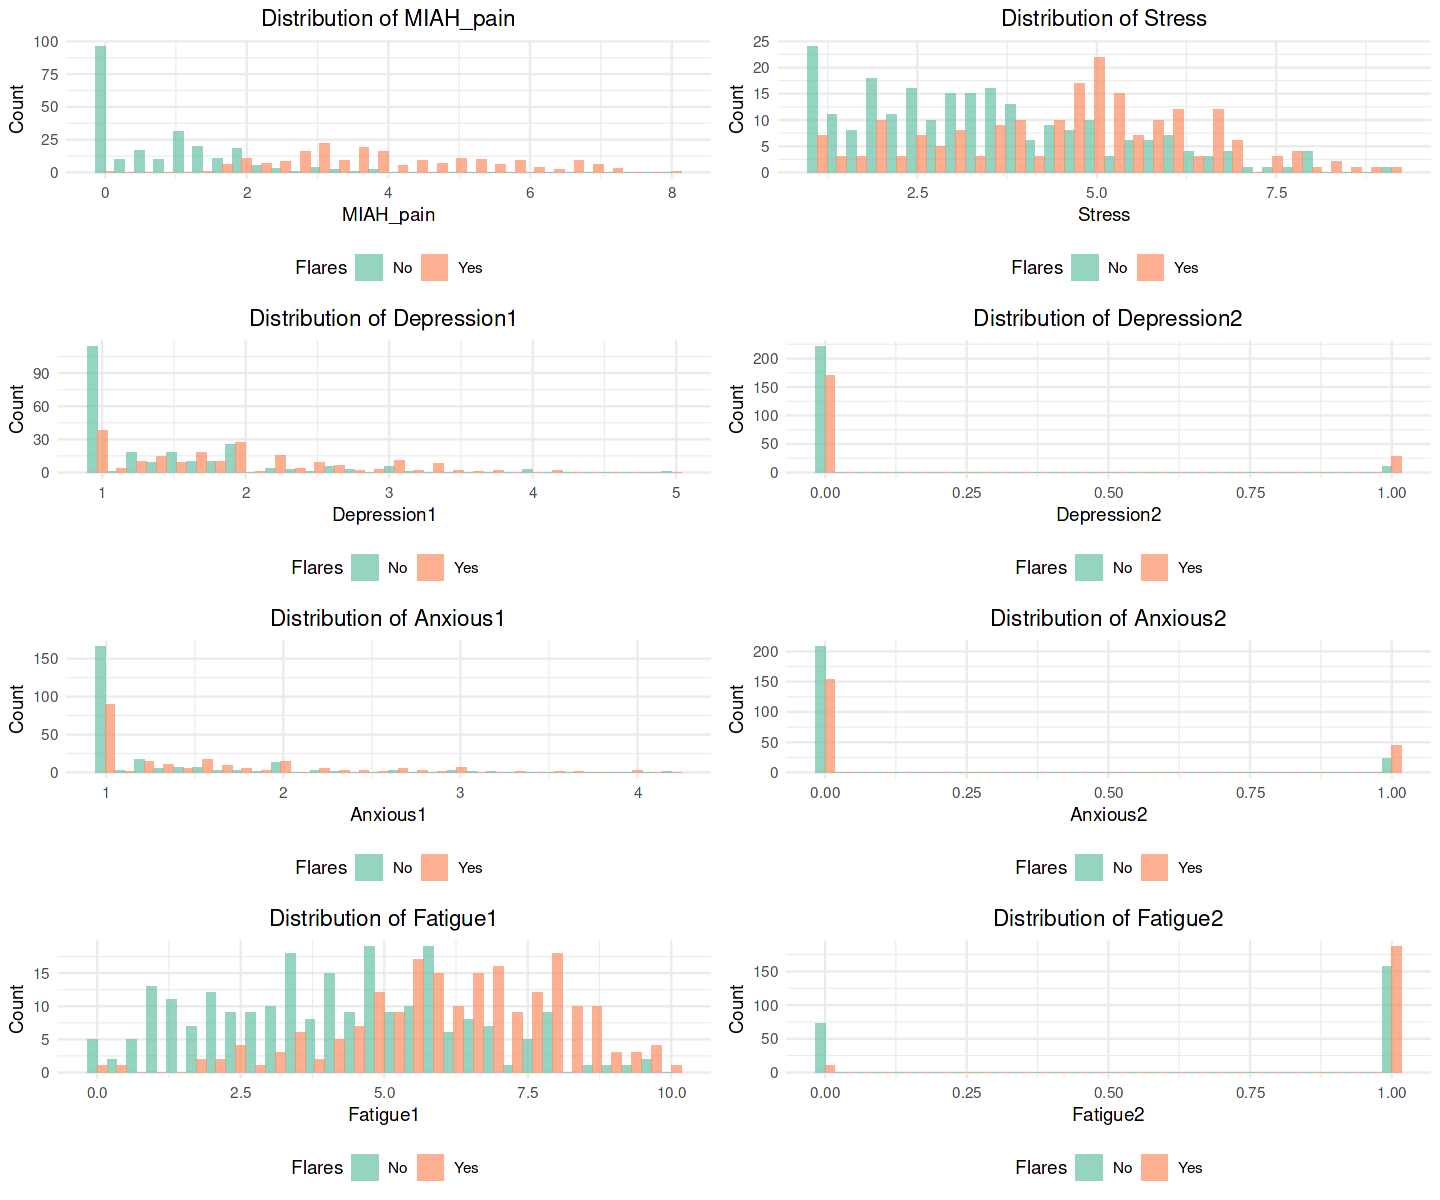

In [17]:
# Load required libraries
library(purrr)
library(gridExtra)

# Get list of numeric columns (excluding GroupNewReversed)
numeric_cols <- names(quantitative_data)[sapply(quantitative_data, is.numeric)]
numeric_cols <- numeric_cols[numeric_cols != "Flares"]

# Function to create histogram for each variable
create_histogram <- function(data, var) {
  ggplot(data, aes(x = .data[[var]], fill = Flares)) +
    geom_histogram(position = "dodge", bins = 30, alpha = 0.7) +
    theme_minimal() +
    labs(title = paste("Distribution of", var),
         x = var,
         y = "Count") +
    theme(legend.position = "bottom",
          plot.title = element_text(hjust = 0.5)) +
    scale_fill_brewer(palette = "Set2")
}

# Create list of plots
plots <- map(numeric_cols, ~create_histogram(quantitative_data, .x))

# Arrange plots in a grid
# Calculate number of rows and columns for grid
n_plots <- length(plots)
n_cols <- min(2, n_plots)
n_rows <- ceiling(n_plots / n_cols)

# Set default figure size
options(repr.plot.width=12, repr.plot.height=10)
# Create grid of plots
grid.arrange(grobs = plots, ncol = n_cols, nrow = n_rows)





## II.3 lifestyle Statistics

In [18]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2,34:36)] %>% 
  select(where(is.factor))

# Define a mapping of variable names to labels
label_mapping <- c(
    LifeEvents_incase = "Life Events",
    Smoking_final  =   "Current smoking at baseline",
    PhysicalExercise = "Physical Exercise"
)

# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage


# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the APA-style table
print(kable(apa_table, format = "markdown", align = "c"))



|      Factor       |  Category   | Flares | Freq | Pct |
|:-----------------:|:-----------:|:------:|:----:|:---:|
| LifeEvents_inCase |     No      |   No   | 102  | 68  |
| LifeEvents_inCase |     No      |  Yes   |  48  | 32  |
| LifeEvents_inCase |     Yes     |   No   | 129  | 46  |
| LifeEvents_inCase |     Yes     |  Yes   | 150  | 54  |
| PhysicalExercise  |    none     |   No   | 166  | 55  |
| PhysicalExercise  |    none     |  Yes   | 135  | 45  |
| PhysicalExercise  | very active |   No   |  65  | 51  |
| PhysicalExercise  | very active |  Yes   |  63  | 49  |
|   Smoking_final   |    Never    |   No   |  98  | 52  |
|   Smoking_final   |    Never    |  Yes   |  90  | 48  |
|   Smoking_final   |   Current   |   No   |  15  | 54  |
|   Smoking_final   |   Current   |  Yes   |  13  | 46  |
|   Smoking_final   |   Former    |   No   | 118  | 55  |
|   Smoking_final   |   Former    |  Yes   |  95  | 45  |


In [19]:
# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
pvalues_df <- p_value_df%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

pvalues_df

,Factor,p_value
,<chr>,<dbl>
LifeEvents_inCase,LifeEvents_inCase,0.00003
PhysicalExercise,Physical Exercise,0.46872
Smoking_final,Current smoking at baseline,0.80616


## II.4 Medicament Statistics

In [20]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2, 37:46)] %>% 
  select(where(is.factor))

# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage

# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the APA-style table
print(kable(apa_table, format = "markdown", align = "c"))



|     Factor     | Category | Flares | Freq | Pct |
|:--------------:|:--------:|:------:|:----:|:---:|
|   Adalimumab   |    No    |   No   | 168  | 54  |
|   Adalimumab   |    No    |  Yes   | 144  | 46  |
|   Adalimumab   |   Yes    |   No   |  58  | 59  |
|   Adalimumab   |   Yes    |  Yes   |  40  | 41  |
|   Adalimumab   |    NA    |   No   |  5   | 26  |
|   Adalimumab   |    NA    |  Yes   |  14  | 74  |
|   Budesonide   |    No    |   No   | 200  | 54  |
|   Budesonide   |    No    |  Yes   | 167  | 46  |
|   Budesonide   |   Yes    |   No   |  27  | 51  |
|   Budesonide   |   Yes    |  Yes   |  26  | 49  |
|   Budesonide   |    NA    |   No   |  4   | 44  |
|   Budesonide   |    NA    |  Yes   |  5   | 56  |
| Geen medicatie |    No    |   No   | 173  | 54  |
| Geen medicatie |    No    |  Yes   | 145  | 46  |
| Geen medicatie |   Yes    |   No   |  54  | 52  |
| Geen medicatie |   Yes    |  Yes   |  50  | 48  |
| Geen medicatie |    NA    |   No   |  4   | 57  |
| Geen med

In [21]:
# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
p_value_df 

Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”


,Factor,p_value
,<chr>,<dbl>
Ustekinumab,Ustekinumab,0.00090
Mesalazine,Mesalazine,0.05109
Infliximab,Infliximab,0.08499
Vedolizumab,Vedolizumab,0.14089
Prednison,Prednison,0.36756
Adalimumab,Adalimumab,0.42336
Budesonide,Budesonide,0.65873
Geen medicatie,Geen medicatie,0.73503
Mercaptopurine,Mercaptopurine,0.80482


## Feature Extraction

In [22]:
# Set dataset parameters
#=========================
## 1. Create data matrix for independent variables 
### one-hotmatrix
model_matrix <- model.matrix(~ . , data = joined_data[c(-1)])
#Display all column names
#column_names <- colnames(model_matrix)
#print(column_names)


## 2. Dependent variable
# ---------------------------
y <- as.numeric(model_matrix[,2])  # Convert y from factor to numeric
y <- ifelse(y == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

Recommended Key Predictors (15-20 max):
- Phenotype: CD
- Age at diagnosis
- Disease duration at diagnosis 
- Montreal B Penetrating
- Montreal L Ileocolonic
- Montreal E pancolitis Diagnosis: Yes
- CCI adjusted: >2
- BMI baseline
- IBD surgery history: Yes
- Stoma history: Yes
- Family history IBD: Yes
- Medication: Ustekinumab: Yes



- Stress
- Fatigue
- Depression
- Anxiety
- Current smoker: Yes
- Physical exercise: Yes
- Life events: Yes


In [23]:
model_matrix <- as.data.frame(model_matrix) %>%
    select(-ends_with("NA")) %>%
    select("FlaresYes","GenderMale" ,"DiseaseEntityUC" ,"AgeatDiag" ,"DiseaseDurationCategory1",                 
"Montreal_L_diag_finalileocolonic","Montreal_B_diag_finalpenetrating","Montreal_E_diag_Finalextensive/pancolitis",
"IBDsurgeryHistory_manualfinalYes"  ,"CCI_adjusted>2" ,"BMI_baseline","Stoma_historyYes"   ,                      
"Family_IBD_final1"   ,"Stress" ,"Depression1"  ,"Anxious1","Fatigue1" ,                             
"Smoking_finalCurrent" ,"LifeEvents_inCaseYes"  ,"PhysicalExercisevery active" ,"UstekinumabYes") %>%
    as.matrix()
column_names <- colnames(model_matrix)
print(column_names)

X <- model_matrix[, -c(1)]# exclude "(Intercept)" , FlaresYes, and MIAH_pain from predictors

 [1] "FlaresYes"                                
 [2] "GenderMale"                               
 [3] "DiseaseEntityUC"                          
 [4] "AgeatDiag"                                
 [5] "DiseaseDurationCategory1"                 
 [6] "Montreal_L_diag_finalileocolonic"         
 [7] "Montreal_B_diag_finalpenetrating"         
 [8] "Montreal_E_diag_Finalextensive/pancolitis"
 [9] "IBDsurgeryHistory_manualfinalYes"         
[10] "CCI_adjusted>2"                           
[11] "BMI_baseline"                             
[12] "Stoma_historyYes"                         
[13] "Family_IBD_final1"                        
[14] "Stress"                                   
[15] "Depression1"                              
[16] "Anxious1"                                 
[17] "Fatigue1"                                 
[18] "Smoking_finalCurrent"                     
[19] "LifeEvents_inCaseYes"                     
[20] "PhysicalExercisevery active"              
[21] "UstekinumabYes

The dependent variable (DV) is `Flares` and four groups of independent variables identified by their indices: `Baseline` ( from 1 to 12) , `psychosocial` (from 13 to 16),  `lifestyle` (from 17 to 19), `Medicament`  (20)

## III.1 Fit the Group Lasso Models
There are SIX models:

[1] "FlaresYes"     
   
**Baseline**                        
[1] "GenderMale"                               
 [2] "DiseaseEntityUC"                          
 [3] "AgeatDiag"                                
 [4] "DiseaseDurationCategory1"                 
 [5] "Montreal_L_diag_finalileocolonic"         
 [6] "Montreal_B_diag_finalpenetrating"         
 [7] "Montreal_E_diag_Finalextensive/pancolitis"
 [8] "IBDsurgeryHistory_manualfinalYes"         
 [9] "CCI_adjusted>2"                           
[10] "BMI_baseline"                             
[11] "Stoma_historyYes"                         
[12] "Family_IBD_final1"

**psychosocial**            
[13] "Stress"                                   
[14] "Depression1"                              
[15] "Anxious1"                                  
[16] "Fatigue1" 
 
 **lifestyle Statistics**      
[17] "Smoking_finalCurrent"                     
[18] "LifeEvents_inCaseYes"                     
[19] "PhysicalExercisevery active"

**Medicament**         
[20] "UstekinumabYes"  


###  Split data into training (70%) and test (30%) sets

Training set (e.g. 70%)
Test set (e.g. 30%)

In [24]:
# 1  Split data into training (70%) and test (30%) sets
set.seed(123) # For reproducibility
n <- length(y)
train_indices <- sample(1:n, size = round(0.7 * n))
test_indices <- setdiff(1:n, train_indices)

# Training data
X_train <- X[train_indices, ]
y_train <- y[train_indices]

# Test data
X_test <- X[test_indices, ]
y_test <- y[test_indices]

cat("Training set size:", length(y_train), "\n")
cat("Test set size:", length(y_test), "\n")

Training set size: 251 
Test set size: 108 



 cross-validation is conducted inside the training set to:
 
Tune hyperparameters (e.g. lambda for G-LASSO) (`cv_gglasso_collect_auc`)

In [25]:
## 2. Create data matrices for independent variables (training set)
x1_train <- as.matrix(X_train[, 1:12]) # Baseline characteristics only
x2_train <- as.matrix(X_train[, c(1:12, 13:16)]) # Baseline + psychosocial
x3_train <- as.matrix(X_train[, c(1:12, 13:16, 17:19)]) # Baseline + psychosocial + lifestyle
x4_train <- as.matrix(X_train[, 1:20]) # All variables
x5_train <- as.matrix(X_train[, 13:16]) # Psychosocial only
x6_train <- as.matrix(X_train[, 17:19]) # Lifestyle only

## 3. Create data matrices for independent variables (test set)
x1_test <- as.matrix(X_test[, 1:12]) 
x2_test <- as.matrix(X_test[, c(1:12, 13:16)])
x3_test <- as.matrix(X_test[, c(1:12, 13:16, 17:19)])
x4_test <- as.matrix(X_test[, 1:20])
x5_test <- as.matrix(X_test[, 13:16])
x6_test <- as.matrix(X_test[, 17:19])

## 4. Define group indices for each model
group_indices1 <- rep(1, 12)
group_indices2 <- c(rep(1, 12), rep(2, 4))
group_indices3 <- c(rep(1, 12), rep(2, 4), rep(3, 3))
group_indices4 <- c(rep(1, 12), rep(2, 4), rep(3, 3), rep(4, 1))
group_indices5 <- rep(1, 4)
group_indices6 <- rep(1, 3)

In [26]:
# Function to perform cross-validation and collect AUC values for each fold using parallel processing
options(repr.plot.width=12, repr.plot.height=5)


cv_gglasso_collect_auc <- function(x, y_input, group_indices, loss = "logit", nfolds = 5, seed = 123) {
  set.seed(seed)
  n <- length(y_input)
  fold_indices <- sample(rep(1:nfolds, length.out = n))

  lambda_max <- max(abs(t(x) %*% y_input)) / n
  lambda_seq <- exp(seq(log(lambda_max), log(lambda_max * 0.0001), length.out = 30))

  cvfit <- cv.gglasso(x = x, y = y_input, group = group_indices, loss = loss,
                      lambda = lambda_seq, nfolds = nfolds, foldid = fold_indices)

  best_lambda <- cvfit$lambda.min

  # Count number of selected variables for each lambda
  coef_mat <- coef(cvfit$gglasso.fit)
  selected_counts <- sapply(1:ncol(coef_mat), function(i) {
    sum(coef_mat[-1, i] != 0)  # exclude intercept
  })

  df <- data.frame(
    log_lambda = log(cvfit$lambda),
    cvm = cvfit$cvm,
    cvsd = cvfit$cvsd,
    selected_vars = selected_counts
  )

  # Custom ggplot
  p <- ggplot(df, aes(x = log_lambda, y = cvm)) +
    geom_errorbar(aes(ymin = cvm - cvsd, ymax = cvm + cvsd), width = 0.1, color = "gray") +
    geom_point(color = "blue", size = 2) +
    geom_vline(xintercept = log(best_lambda), linetype = "dashed", color = "red") +
    scale_x_continuous(
      name = "log(lambda)",
      sec.axis = sec_axis(
          transform = ~.,
          name = "Number of selected variables",
          breaks = log(cvfit$lambda),
          labels = selected_counts)
    ) +
    ylab("Cross-validated loss") +
    theme_bw() +
    ggtitle("Cross-validation Curve with Selected Variable Count")+
    theme(
        axis.text.x = element_text(size = 14),
        axis.text.x.top = element_text(size = 14),
        axis.text.y = element_text(size = 14),
        axis.title = element_text(size = 16),
        plot.title = element_text(size = 18, face = "bold")
  )

  print(p)

  # Compute fold AUCs
  fold_aucs <- sapply(1:nfolds, function(i) {
    train_idx <- which(fold_indices != i)
    test_idx <- which(fold_indices == i)

    model <- gglasso(x = x[train_idx, , drop = FALSE],
                     y = y_input[train_idx],
                     group = group_indices,
                     loss = loss,
                     lambda = best_lambda)

    probs <- plogis(predict(model, newx = x[test_idx, , drop = FALSE], type = "link"))
    y_test_bin <- ifelse(y_input[test_idx] == -1, 0, 1)

    suppressMessages(suppressWarnings(
      auc(roc(y_test_bin, probs, quiet = TRUE))
    ))
  })

  mean_auc <- mean(fold_aucs)
  sd_auc <- sd(fold_aucs)
  margin <- qt(0.975, df = nfolds - 1) * sd_auc / sqrt(nfolds)

  final_model <- gglasso(x = x, y = y_input, group = group_indices, loss = loss, lambda = best_lambda)

  return(list(
    fold_auc_values = fold_aucs,
    mean_auc = mean_auc,
    sd_auc = sd_auc,
    margin = margin,
    ci_lower = mean_auc - margin,
    ci_upper = mean_auc + margin,
    model = final_model,
    lambda = best_lambda,
    selected_variable_count = sum(coef(final_model)[-1] != 0)
  ))
}


## Model 5: Model with only Psychosocial factors 
 

Model 5 completed


Time difference of 0.009555535 mins

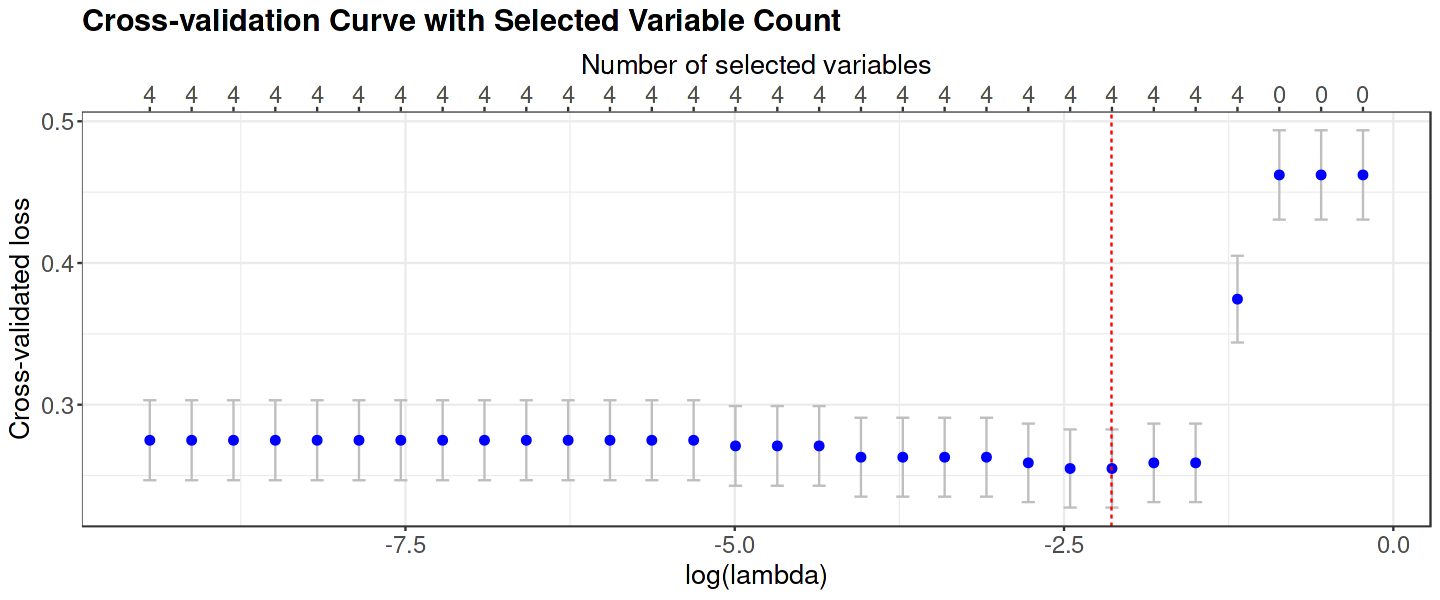

In [27]:
start_time <- Sys.time()
cv_results5 <- cv_gglasso_collect_auc(x5_train, y_train, group_indices5)
cat("Model 5 completed\n")
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

## Model 6: Model with only lifestyle factors

Model 6 completed


Time difference of 0.005060554 mins

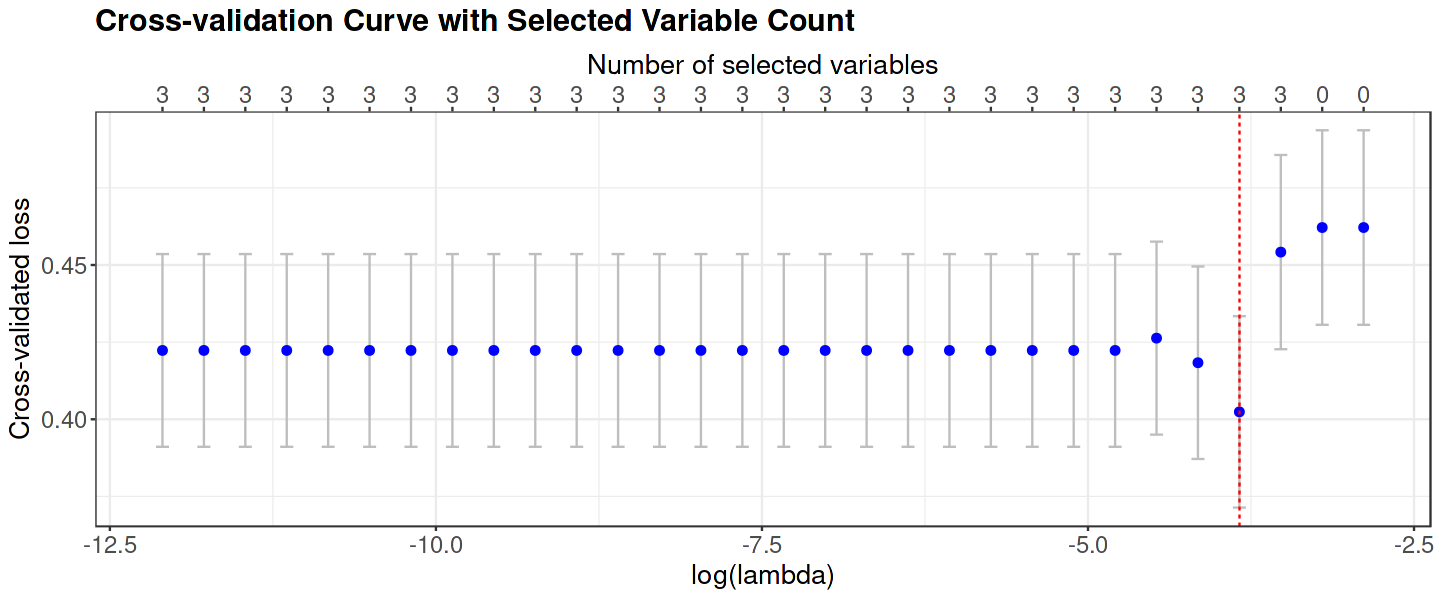

In [28]:
# Run cross-validation for each model and collect fold-specific AUC values
start_time <- Sys.time()
cv_results6 <- cv_gglasso_collect_auc(x6_train, y_train, group_indices6)
cat("Model 6 completed\n")
  
# Record end time and calculate total runtime
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

## Model 1: BaseLine model 

Running cross-validation for 6 models 
Model 1 completed


Time difference of 0.9541185 mins

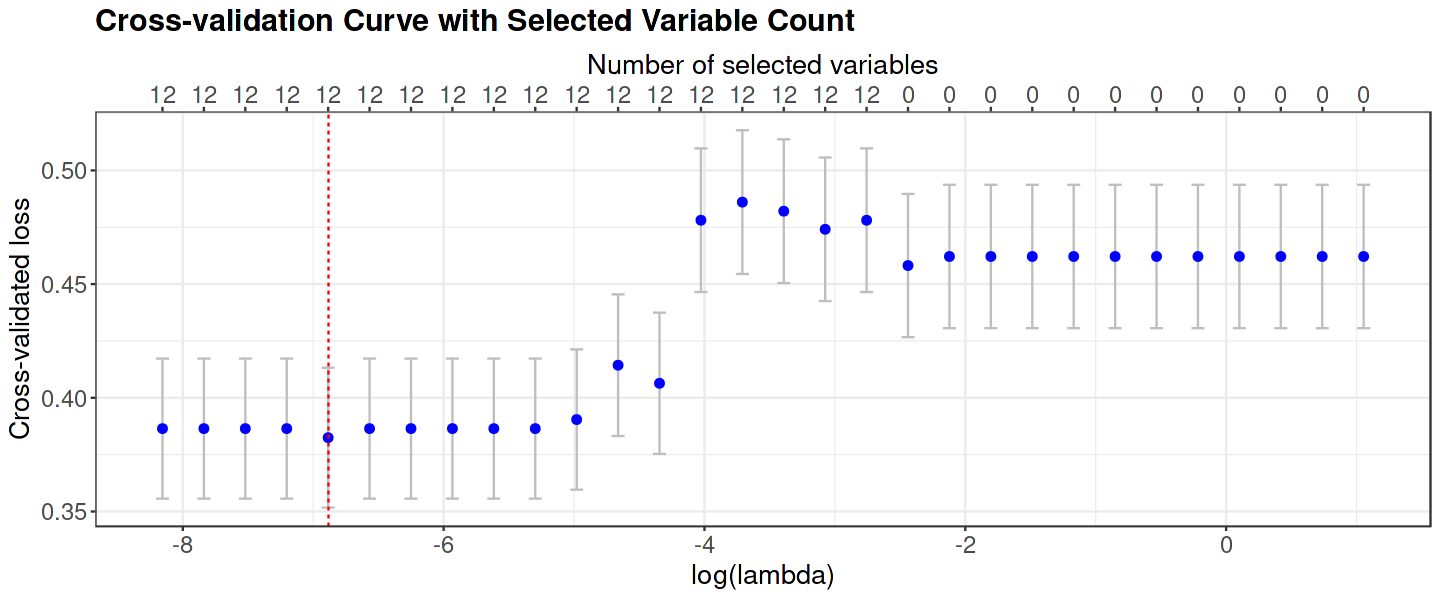

In [29]:
# Now run the cross-validation for each model using parallel processing
cat("Running cross-validation for 6 models \n")
# Record start time
start_time <- Sys.time()
cv_results1 <- cv_gglasso_collect_auc(x1_train, y_train, group_indices1)
cat("Model 1 completed\n")
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

## Model 2: BaseLine + psychosocial model 

Model 2 completed


Time difference of 1.683926 mins

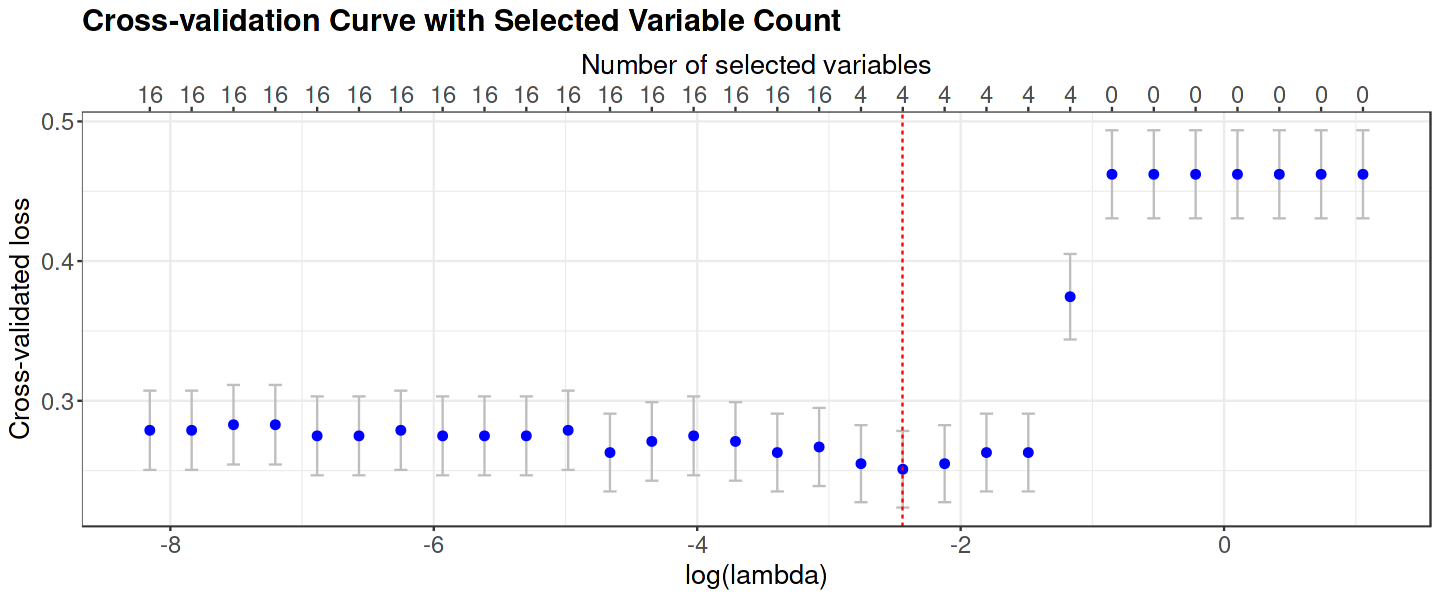

In [30]:
start_time <- Sys.time()
cv_results2 <- cv_gglasso_collect_auc(x2_train, y_train, group_indices2)
cat("Model 2 completed\n")
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

##  Model 3: BaseLine + psychosocial + lifestyle model 

Model 3 completed


Time difference of 2.219864 mins

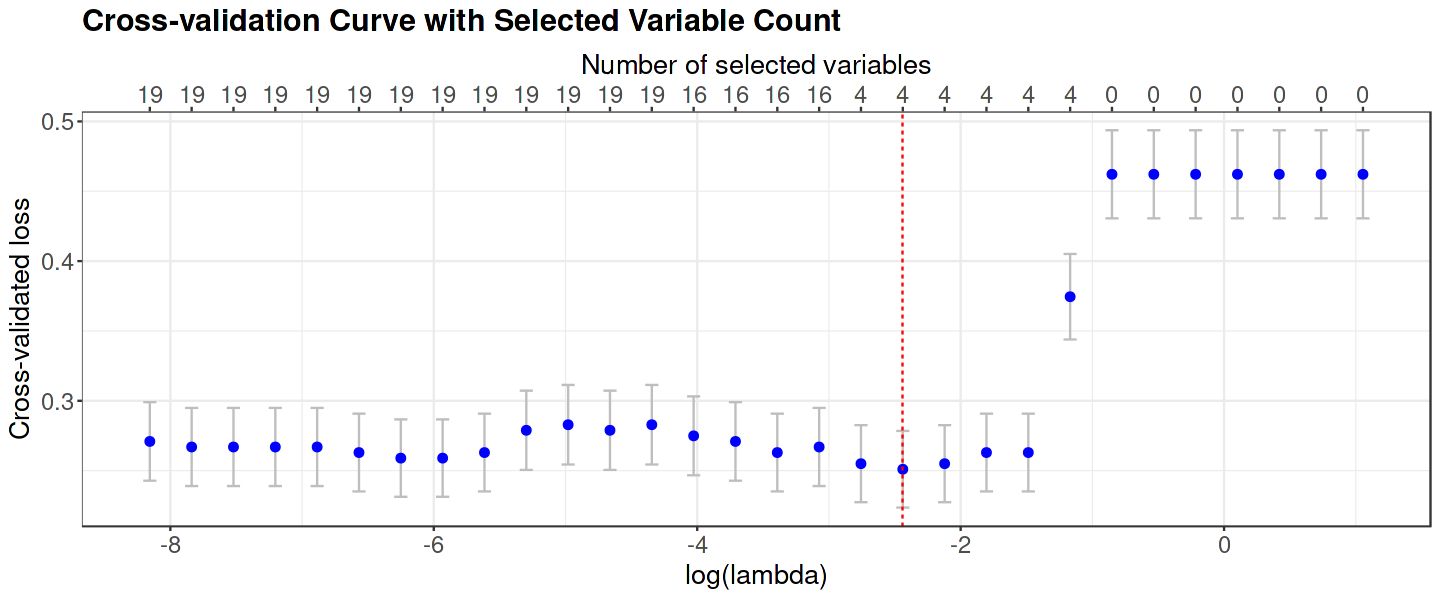

In [31]:
start_time <- Sys.time()
cv_results3 <- cv_gglasso_collect_auc(x3_train, y_train, group_indices3)
cat("Model 3 completed\n")
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

##  Model 4: BaseLine + psychosocial + lifestyle model + Med

add 20 (Ustekinumab) in medication group

Model 4 completed


Time difference of 2.93107 mins

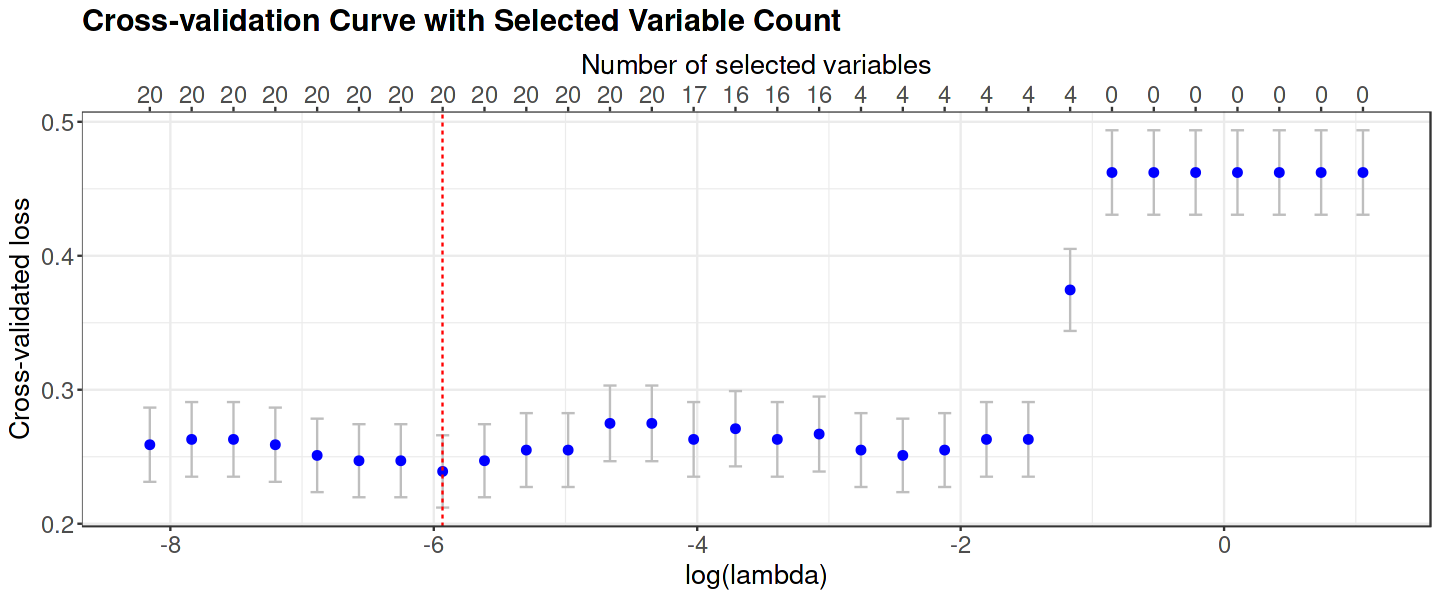

In [32]:
start_time <- Sys.time()
cv_results4 <- cv_gglasso_collect_auc(x4_train, y_train, group_indices4)
cat("Model 4 completed\n")
end_time <- Sys.time()
difftime(end_time, start_time, units = "mins")
cat("\n\n")

**Print cross-validation results with confidence intervals**

In [33]:
## Print cross-validation results with confidence intervals
cat("\n--- Cross-Validation Results (on Training Set) ---\n")
  cat("Model 1: Baseline characteristics only - AUC:", round(cv_results1$mean_auc, 3), 
      "95% CI: [", round(cv_results1$ci_lower, 3), "-", round(cv_results1$ci_upper, 3), "]\n")
  cat("Model 2: BaseLine + Psychosocial - AUC:", round(cv_results2$mean_auc, 3), 
      "95% CI: [", round(cv_results2$ci_lower, 3), "-", round(cv_results2$ci_upper, 3), "]\n")
  cat("Model 3: BaseLine + Psychosocial + Lifestyle - AUC:", round(cv_results3$mean_auc, 3), 
      "95% CI: [", round(cv_results3$ci_lower, 3), "-", round(cv_results3$ci_upper, 3), "]\n")
  cat("Model 4: BaseLine + Psychosocial + Lifestyle + Medical - AUC:", round(cv_results4$mean_auc, 3), 
      "95% CI: [", round(cv_results4$ci_lower, 3), "-", round(cv_results4$ci_upper, 3), "]\n")
  cat("Model 5: Psychosocial only - AUC:", round(cv_results5$mean_auc, 3), 
      "95% CI: [", round(cv_results5$ci_lower, 3), "-", round(cv_results5$ci_upper, 3), "]\n")
  cat("Model 6: Lifestyle only - AUC:", round(cv_results6$mean_auc, 3), 
      "95% CI: [", round(cv_results6$ci_lower, 3), "-", round(cv_results6$ci_upper, 3), "]\n")



--- Cross-Validation Results (on Training Set) ---
Model 1: Baseline characteristics only - AUC: 0.639 95% CI: [ 0.583 - 0.694 ]
Model 2: BaseLine + Psychosocial - AUC: 0.799 95% CI: [ 0.706 - 0.892 ]
Model 3: BaseLine + Psychosocial + Lifestyle - AUC: 0.799 95% CI: [ 0.706 - 0.892 ]
Model 4: BaseLine + Psychosocial + Lifestyle + Medical - AUC: 0.817 95% CI: [ 0.73 - 0.904 ]
Model 5: Psychosocial only - AUC: 0.799 95% CI: [ 0.707 - 0.89 ]
Model 6: Lifestyle only - AUC: 0.637 95% CI: [ 0.582 - 0.692 ]


## III.2 Performance Metrics

We are going to summarize the Group Lasso models, extract results, compute performance metrics (accuracy, AUC, and AIC), and visualize regression coefficients:



### 1. Extract and display the significant variables from each g-lasso model;
 
 we need to extract the non-zero coefficients from each optimal model. In Lasso and Group Lasso models, variables with non-zero coefficients are considered significant:

In [34]:
# Create a function to display non-zero coefs
significant_coefs <- function(coefs,x) {
    coefs =round(coefs,4)
    # Get the names of variables with non-zero coefficients
    significant_vars <- colnames(x)[which(coefs[-1] != 0)]
    significant_vars <- c("(Intercept)", significant_vars)
    # Print the significant variables and their coefficients
    new_coefs <- coefs[c(1, which(coefs[-1] != 0) + 1)]
    significant_df <- data.frame(
        Variable =  significant_vars, Coefficient = new_coefs)
    print(significant_df)
}

# Extract coefficients for each model
coef_model1 <- coef(cv_results1$model)
coef_model2 <- coef(cv_results2$model)
coef_model3 <- coef(cv_results3$model)
coef_model4 <- coef(cv_results4$model)
coef_model5 <- coef(cv_results5$model)
coef_model6 <- coef(cv_results6$model)


len_model1 <- cv_results1$selected_variable_count
len_model2 <- cv_results2$selected_variable_count
len_model3 <- cv_results3$selected_variable_count
len_model4 <- cv_results4$selected_variable_count
len_model5 <- cv_results5$selected_variable_count
len_model6 <- cv_results6$selected_variable_count



In [35]:
# Display results
cat('Coefficients for Model 1: Baseline characteristics only\n')
significant_coefs(coef_model1,x1_train)

Coefficients for Model 1: Baseline characteristics only
                                    Variable Coefficient
1                                (Intercept)      1.6983
2                                 GenderMale     -0.9072
3                            DiseaseEntityUC      0.2755
4                                  AgeatDiag      0.0044
5                   DiseaseDurationCategory1      0.9317
6           Montreal_L_diag_finalileocolonic     -0.4020
7           Montreal_B_diag_finalpenetrating     -0.4731
8  Montreal_E_diag_Finalextensive/pancolitis     -0.8391
9           IBDsurgeryHistory_manualfinalYes     -0.1085
10                            CCI_adjusted>2     -0.3135
11                              BMI_baseline     -0.0542
12                          Stoma_historyYes      0.0737
13                         Family_IBD_final1     -0.0962


In [36]:
cat('Coefficients for Model 2: BaseLine + Psychosocial')
significant_coefs(coef_model2,x2_train)

Coefficients for Model 2: BaseLine + Psychosocial     Variable Coefficient
1 (Intercept)      2.4624
2      Stress     -0.1642
3 Depression1     -0.0778
4    Anxious1     -0.0541
5    Fatigue1     -0.2764


In [37]:
cat('Coefficients for Model 3: BaseLine + Psychosocial + Lifestyle\n')
significant_coefs(coef_model3,x3_train)

Coefficients for Model 3: BaseLine + Psychosocial + Lifestyle
     Variable Coefficient
1 (Intercept)      2.4624
2      Stress     -0.1642
3 Depression1     -0.0778
4    Anxious1     -0.0541
5    Fatigue1     -0.2764


In [38]:
cat('Coefficients for Model 4: BaseLine + Psychosocial + Lifestyle + Medical\n')
significant_coefs(coef_model4,x4_train)

Coefficients for Model 4: BaseLine + Psychosocial + Lifestyle + Medical
                                    Variable Coefficient
1                                (Intercept)      5.5007
2                                 GenderMale     -0.2917
3                            DiseaseEntityUC     -0.0662
4                                  AgeatDiag      0.0078
5                   DiseaseDurationCategory1      0.6218
6           Montreal_L_diag_finalileocolonic     -0.1921
7           Montreal_B_diag_finalpenetrating     -0.1040
8  Montreal_E_diag_Finalextensive/pancolitis     -0.7076
9           IBDsurgeryHistory_manualfinalYes     -0.1309
10                            CCI_adjusted>2     -0.1554
11                              BMI_baseline     -0.0586
12                          Stoma_historyYes      0.3913
13                         Family_IBD_final1     -0.1037
14                                    Stress     -0.1885
15                               Depression1     -0.2350
16              

In [39]:
cat('Coefficients for Model 5: Psychosocial only')
significant_coefs(coef_model5,x5_train)

Coefficients for Model 5: Psychosocial only     Variable Coefficient
1 (Intercept)      2.1242
2      Stress     -0.1419
3 Depression1     -0.0627
4    Anxious1     -0.0431
5    Fatigue1     -0.2372


In [40]:
cat('Coefficients for Model 6: Lifestyle only')
significant_coefs(coef_model6, x6_train)

Coefficients for Model 6: Lifestyle only                     Variable Coefficient
1                 (Intercept)      0.4449
2        Smoking_finalCurrent      0.0023
3        LifeEvents_inCaseYes     -0.3637
4 PhysicalExercisevery active     -0.1836


###  2. Evaluate the final model on the untouched 30% test set

In [41]:
# Function to calculate metrics
calculate_metrics <- function(actual, predicted) {
    confusion_matrix <- table(factor(actual), factor(predicted))
    
    sensitivity <- confusion_matrix[2,2] / sum(confusion_matrix[2,])   # True Positives / (True Positives + False Negatives)
    specificity <- confusion_matrix[1,1] / sum(confusion_matrix[1,])   # True Negatives / (True Negatives + False Positives)
    ppv <- confusion_matrix[2,2] / sum(confusion_matrix[,2])            # True Positives / (True Positives + False Positives)
    npv <- confusion_matrix[1,1] / sum(confusion_matrix[,1])            # True Negatives / (True Negatives + False Negatives)
    
    return(c(Sensitivity = sensitivity,
             Specificity = specificity,
             PPV = ppv,
             NPV = npv))
}

In [42]:
cat("\n--- Cross-Validation Results (on Testing Set) ---\n")

# Function to compute performance metrics
compute_metrics <- function(model, x_test) {
    predicted_probs <- plogis(predict(model, newx = x_test, type = "link")) # Use link for probabilities
    y_binary <- factor(ifelse(y_test == -1, 0, 1))
    
    # Calculate ROC curve
    suppressMessages(suppressWarnings(
        roc_curve <- roc(y_binary, as.vector(predicted_probs))))
    
    # Find optimal threshold
    optimal_threshold <- coords(roc_curve, "best", ret = "threshold")
   
    # Convert probabilities to predicted classes using optimal threshold
    predicted_classes <- ifelse(predicted_probs > optimal_threshold$threshold, 1, 0)
    
    # Calculate accuracy
    accuracy <- mean(predicted_classes == y_binary)
    
    # Calculate AUC
    suppressMessages(suppressWarnings(
        auc_value <- auc(roc_curve)))
    
    # Calculate metrics for each model
    metrics_model <- calculate_metrics(y_binary, predicted_classes)
    
    return(list(
        accuracy = accuracy, 
        auc = auc_value, 
        roc_curve=roc_curve,
        metrics = metrics_model
    ))
}
# Compute metrics for all models
metrics_model1 <- compute_metrics(model = cv_results1$model, x=x1_test)
metrics_model2 <- compute_metrics(model = cv_results2$model, x=x2_test)
metrics_model3 <- compute_metrics(model = cv_results3$model, x=x3_test)
metrics_model4 <- compute_metrics(model = cv_results4$model, x=x4_test)
metrics_model5 <- compute_metrics(model = cv_results5$model, x=x5_test)
metrics_model6 <- compute_metrics(model = cv_results6$model, x=x6_test)

# Print performance metrics
cat("Model 1: Baseline characteristics only - Accuracy:", metrics_model1$accuracy, "AUC:", metrics_model1$auc, "  (95% CI: [", round(metrics_model1$auc-cv_results1$margin, 3), "-", round(metrics_model1$auc+cv_results1$margin, 3), "])\n")
cat("Model 2: BaseLine + Psychosocial - Accuracy:", metrics_model2$accuracy, "AUC:", metrics_model2$auc, " (95% CI: [", round(metrics_model2$auc-cv_results2$margin, 3), "-", round(metrics_model2$auc+cv_results2$margin, 3), "])\n")
cat("Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy:", metrics_model3$accuracy, "AUC:", metrics_model3$auc,  " (95% CI: [", round(metrics_model3$auc-cv_results3$margin, 3), "-", round(metrics_model3$auc+cv_results3$margin, 3), "])\n")
cat("Model 4: BaseLine + Psychosocial + Lifestyle + Medical - Accuracy:", metrics_model4$accuracy, "AUC:", metrics_model4$auc,  " (95% CI: [", round(metrics_model4$auc-cv_results4$margin, 3), "-", round(metrics_model4$auc+cv_results4$margin, 3), "])\n")
cat("Model 5: Psychosocial only - Accuracy:", metrics_model5$accuracy, "AUC:", metrics_model5$auc,   " (95% CI: [", round(metrics_model5$auc-cv_results5$margin, 3), "-", round(metrics_model5$auc+cv_results5$margin, 3), "])\n")
cat("Model 6: Lifestyle only - Accuracy:", metrics_model6$accuracy, "AUC:", metrics_model6$auc,   " (95% CI: [", round(metrics_model6$auc-cv_results6$margin, 3), "-", round(metrics_model6$auc+cv_results6$margin, 3), "])\n")
    


--- Cross-Validation Results (on Testing Set) ---
Model 1: Baseline characteristics only - Accuracy: 0.5925926 AUC: 0.6143113   (95% CI: [ 0.559 - 0.67 ])
Model 2: BaseLine + Psychosocial - Accuracy: 0.6759259 AUC: 0.7388193  (95% CI: [ 0.646 - 0.832 ])
Model 3: BaseLine + Psychosocial + Lifestyle - Accuracy: 0.6759259 AUC: 0.7388193  (95% CI: [ 0.646 - 0.832 ])
Model 4: BaseLine + Psychosocial + Lifestyle + Medical - Accuracy: 0.7222222 AUC: 0.7635063  (95% CI: [ 0.676 - 0.851 ])
Model 5: Psychosocial only - Accuracy: 0.6759259 AUC: 0.7391771  (95% CI: [ 0.648 - 0.831 ])
Model 6: Lifestyle only - Accuracy: 0.5555556 AUC: 0.5586762  (95% CI: [ 0.504 - 0.613 ])


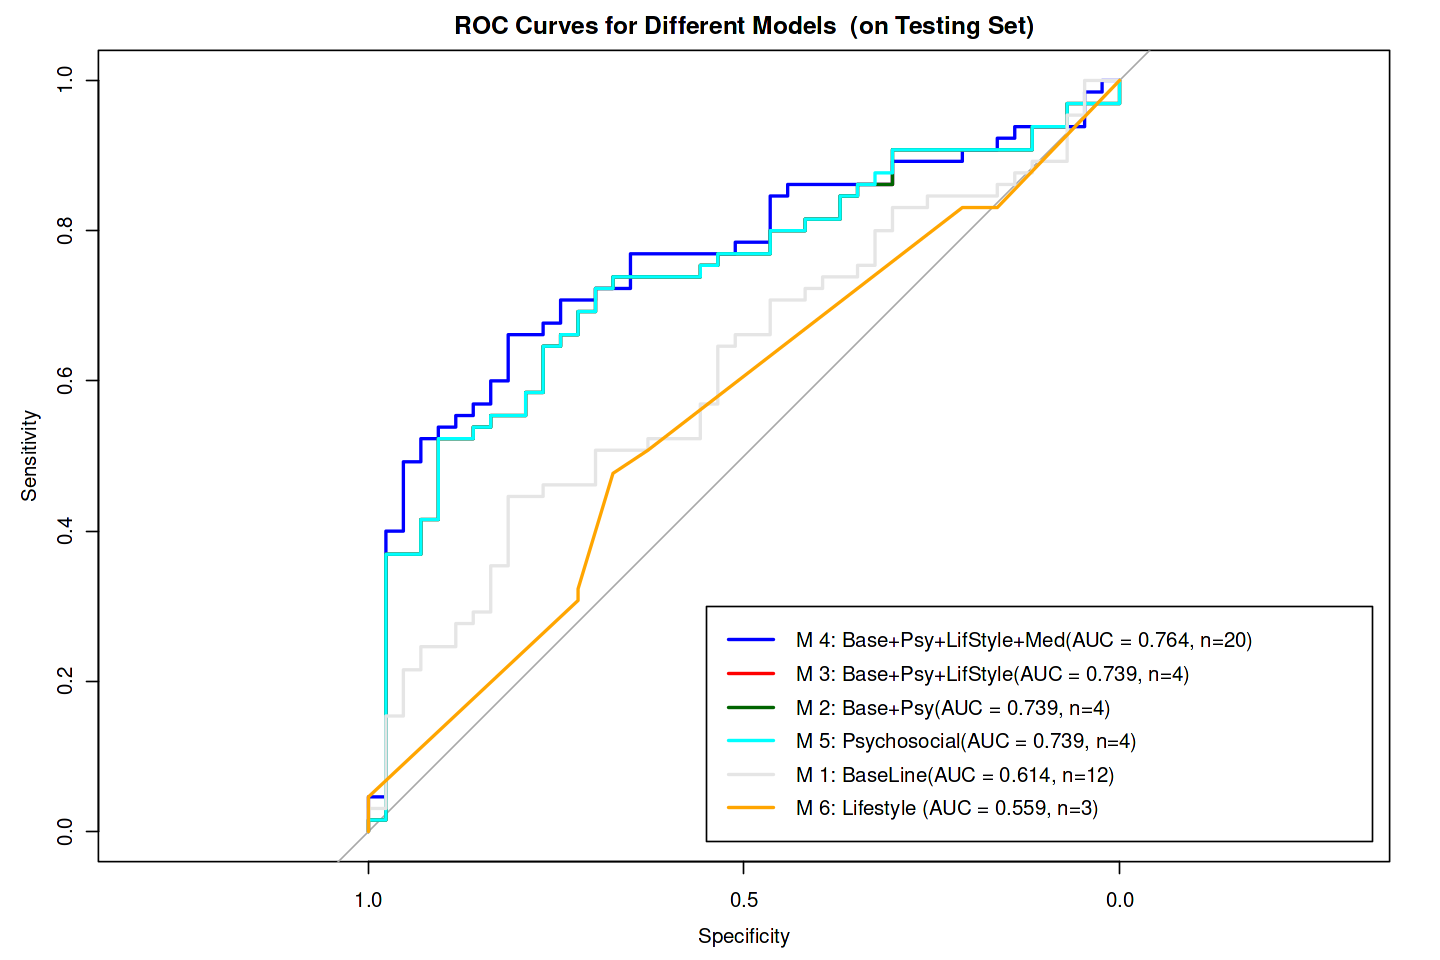

In [50]:
# Plot ROC Curves for All Models
roc_model1 <- metrics_model1$roc_curve
roc_model2 <- metrics_model2$roc_curve
roc_model3 <- metrics_model3$roc_curve
roc_model4 <- metrics_model4$roc_curve
roc_model5 <- metrics_model5$roc_curve
roc_model6 <- metrics_model6$roc_curve

# ROC plot
# Prepare legend labels with model names and AUC values
    legend_labels <- c(
        paste0("M 4: Base+Psy+LifStyle+Med(AUC = ", sprintf("%.3f", auc(roc_model4)), ", n=",len_model4,")"),
        paste0("M 3: Base+Psy+LifStyle(AUC = ", sprintf("%.3f", auc(roc_model3)), ", n=",len_model3, ")"),
        paste0("M 2: Base+Psy(AUC = ", sprintf("%.3f", auc(roc_model2)),  ", n=",len_model2,")"),
        paste0("M 5: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model5)),  ", n=",len_model5,")"),
        paste0("M 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1)),  ", n=",len_model1,")"),
        paste0("M 6: Lifestyle (AUC = ", sprintf("%.3f", auc(roc_model6)),  ", n=",len_model6,")")
    )
options(repr.plot.width=12, repr.plot.height=8)
# Create ROC plot
plot(roc_model4, col = "blue", main = "ROC Curves for Different Models  (on Testing Set)")
plot(roc_model3, col = "red", add = TRUE)
plot(roc_model2, col = "darkgreen", add = TRUE)
plot(roc_model5, col = "cyan", add = TRUE)
plot(roc_model1, col = "gray90", add = TRUE)
plot(roc_model6, col = "orange", add = TRUE)
    
# Add legend
legend(x = 0.55, y = 0.3, 
        legend = legend_labels,
        col = c("blue", "red", "darkgreen", "cyan", "gray90", "orange"),
        lwd = 2)
    

In [44]:
# Create a results table
results_table <- data.frame(
    Model = c("Model 1: BaseLine", 
              "Model 2: BaseLine +Psychosocial", 
              "Model 3: BaseLine+P+Lifestyle", 
              "Model 4: BaseLine+P+Lifestyle+Med",               
              "Model 5: Psychosocial", 
              "Model 6: Lifestyle"),
    Sensitivity = c(metrics_model1$metrics[1], metrics_model2$metrics[1],
                    metrics_model3$metrics[1],metrics_model4$metrics[1],
                   metrics_model5$metrics[1], metrics_model6$metrics[1]),
    
    Specificity = c(metrics_model1$metrics[2], metrics_model2$metrics[2],
                    metrics_model3$metrics[2], metrics_model4$metrics[2],
                    metrics_model5$metrics[2], metrics_model6$metrics[2]),
    
    PPV = c(metrics_model1$metrics[3], metrics_model2$metrics[3],
            metrics_model3$metrics[3], metrics_model4$metrics[3],
           metrics_model5$metrics[3], metrics_model6$metrics[3]),
    
    NPV = c(metrics_model1$metrics[4], metrics_model2$metrics[4],
            metrics_model3$metrics[4],metrics_model4$metrics[4],
            metrics_model5$metrics[4], metrics_model6$metrics[4])
)

# Print the results table
print(results_table)

                              Model Sensitivity Specificity       PPV       NPV
1                 Model 1: BaseLine   0.4461538   0.8139535 0.7837838 0.4929577
2   Model 2: BaseLine +Psychosocial   0.5230769   0.9069767 0.8947368 0.5571429
3     Model 3: BaseLine+P+Lifestyle   0.5230769   0.9069767 0.8947368 0.5571429
4 Model 4: BaseLine+P+Lifestyle+Med   0.6615385   0.8139535 0.8431373 0.6140351
5             Model 5: Psychosocial   0.5230769   0.9069767 0.8947368 0.5571429
6                Model 6: Lifestyle   0.4769231   0.6744186 0.6888889 0.4603175


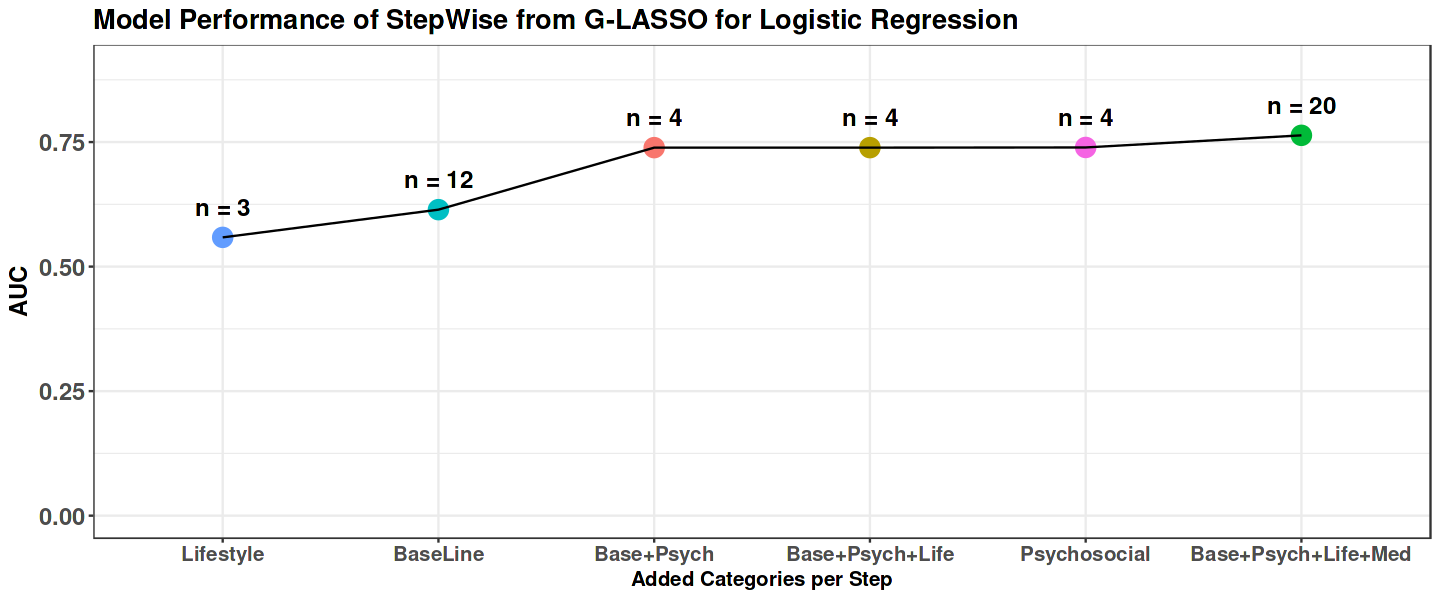

In [45]:
options(repr.plot.width=12, repr.plot.height=5)
# data frame for models importance
variable_importance <- data.frame(
  Variable = c("BaseLine", "Base+Psych", "Base+Psych+Life", 
               "Base+Psych+Life+Med",
               "Psychosocial", "Lifestyle"),
  auc_values = c(metrics_model1$auc, metrics_model2$auc, 
                 metrics_model3$auc, metrics_model4$auc,
                metrics_model5$auc, metrics_model6$auc),
  n_vars = c(len_model1, len_model2, len_model3, len_model4, len_model5, len_model6)
)

# Create Figure : Variable Importance Plot
ggplot(variable_importance, aes(x = reorder(Variable, auc_values), y = auc_values)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 12) +
  geom_text(aes(label = paste0("n = ", n_vars)), 
            vjust = -1.2, size = 5, fontface = "bold") +  # Adjust `vjust` as needed
    ylim(0, .9) +  # Set Y-axis from 0 to 1
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic Regression",
       x = "Added Categories per Step",
       y = "AUC") +
  theme_bw() +
  theme(
    legend.position = "none",
    plot.title = element_text(size = 16, face = "bold"),
    axis.title.x = element_text(size = 12, face = "bold"),
    axis.title.y = element_text(size = 14, face = "bold"),
    axis.text.x = element_text(size = 12, face = "bold"),
    axis.text.y = element_text(size = 14, face = "bold")
  )


### 3. Statistical Test on all models

We're going to conduct a statistical test to formally compare the performance of our six models. Since we're comparing the same metric (AUC) across multiple related models on the same dataset, either Repeated Measures ANOVA or the Friedman test would be appropriate.



**Normality Testing**

Normality was assessed for all models using Shapiro-Wilk tests. Results indicated that the assumption of normality was met for all models: Model 1 (W = 0.78, p = .052), Model 2 (W = 0.94, p = .640), Model 3 (W = 0.94, p = .640), Model 4 (W = 0.91, p = .447), Model 5 (W = 0.94, p = .666), and Model 6 (W = 0.88, p = .293).

Interpretation

All models pass the normality test since all p-values are greater than the standard alpha level of 0.05, which means we cannot reject the null hypothesis that the data comes from a normal distribution.

Model 1 has a p-value (0.05167) that is very close to the significance threshold of 0.05. While technically it still passes the normality test, it shows the weakest evidence of normality among all six models.
Models 2 and 3 have identical test statistics (W = 0.93631) and p-values (0.64), which indicates they likely have very similar distributions of AUC values. This might suggest that the additions in Model 3 compared to Model 2 don't substantially change the distribution of performance across folds.
Model 5 shows the strongest evidence of normality with the highest W statistic (0.93997) and p-value (0.6657).



In [46]:
# dataset: AUC values for each model
# Each row represents a fold/iteration, columns are different models
auc_values <- data.frame(
  model_1 = cv_results1$fold_auc_values,
  model_2 = cv_results2$fold_auc_values,
  model_3 = cv_results3$fold_auc_values,
  model_4 = cv_results4$fold_auc_values,
  model_5 = cv_results5$fold_auc_values,
  model_6 = cv_results6$fold_auc_values
)

auc_values
# Check for normality
shapiro_results <- lapply(auc_values, shapiro.test)
shapiro_results

model_1,model_2,model_3,model_4,model_5,model_6
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.6031746,0.8603175,0.8603175,0.9000000,0.8555556,0.6626984
0.6834416,0.7110390,0.7110390,0.7581169,0.7110390,0.5925325
0.6016667,0.8066667,0.8066667,0.8233333,0.8050000,0.6533333
0.6907051,0.8814103,0.8814103,0.8685897,0.8830128,0.6875000
0.6141215,0.7356322,0.7356322,0.7356322,0.7389163,0.5886700


$model_1

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.77674, p-value = 0.05167


$model_2

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.91864, p-value = 0.5212


$model_3

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.91864, p-value = 0.5212


$model_4

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.93865, p-value = 0.6564


$model_5

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.93777, p-value = 0.6502


$model_6

	Shapiro-Wilk normality test

data:  X[[i]]
W = 0.87623, p-value = 0.2926



**Statistical Approach Based on These Results**

Since all models satisfy the normality assumption, we can proceed with parametric tests:

Use Repeated Measures ANOVA rather than the non-parametric Friedman test, as the normality assumption is met for all models.

Follow up with paired t-tests with appropriate correction (like Bonferroni) for multiple comparisons if the ANOVA shows significant differences.

**Repeated Measures ANOVA**

A one-way repeated measures ANOVA was conducted to determine whether there were statistically significant differences in AUC values among the six predictive models. The results revealed a statistically significant difference, F(5, 20) = 26.70, p < .001, indicating that model performance varied significantly across the different modeling approaches.

In [47]:
# Repeated measures ANOVA in R
# First create a subject ID variable

auc_values$subject <- as.factor(1:nrow(auc_values))

# Convert to long format properly
auc_long <- reshape2::melt(auc_values, 
                           id.vars = "subject",
                           variable.name = "model", 
                           value.name = "auc")

# Run repeated measures ANOVA with proper Error term
aov_result <- aov(auc ~ model + Error(subject/model), data = auc_long)
summary(aov_result)


Error: subject
          Df  Sum Sq Mean Sq F value Pr(>F)
Residuals  4 0.07441  0.0186               

Error: subject:model
          Df  Sum Sq Mean Sq F value   Pr(>F)    
model      5 0.18426 0.03685   26.93 3.08e-08 ***
Residuals 20 0.02737 0.00137                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

**Post-hoc Analysis**

Pairwise comparisons using paired t-tests with Bonferroni correction revealed that Model 6 performed significantly differently from Model 2 (p = .005), Model 3 (p = .005), Model 4 (p = .007), and Model 5 (p = .005). No other pairwise comparisons reached statistical significance (all ps > .05).

In [48]:
# Post-hoc pairwise comparisons
pairwise.t.test(auc_long$auc, auc_long$model, paired = TRUE, p.adjust.method = "bonferroni")


	Pairwise comparisons using paired t tests 

data:  auc_long$auc and auc_long$model 

        model_1 model_2 model_3 model_4 model_5
model_2 0.2172  -       -       -       -      
model_3 0.2172  -       -       -       -      
model_4 0.1386  1.0000  1.0000  -       -      
model_5 0.2049  1.0000  1.0000  1.0000  -      
model_6 1.0000  0.0058  0.0058  0.0042  0.0052 

P value adjustment method: bonferroni 

## 4. Interpretation of Group LASSO Models 

**Model Performance**
Cross-validation results revealed differential performance across the six predictive models. On the testing set, performance metrics varied substantially, with AUC values ranging from 0.559 to 0.762. Repeated measures ANOVA showed a statistically significant difference in model performance, F(5, 20) = 26.70, p < .001.

Post-hoc pairwise comparisons using Bonferroni correction revealed that Model 6 (Lifestyle only) performed significantly worse than Models 2-5 (all ps < .01). No statistically significant differences were found among Models 2-5, suggesting comparable predictive performance despite their differing complexity.


**Model Coefficients Analysis**

_Model 1: Baseline Characteristics Only (AUC = 0.614)_

Baseline demographic and clinical characteristics demonstrated modest predictive value. The strongest predictors of IBD flares included disease duration category (β = 0.932) and male gender (β = -0.907), suggesting that longer disease duration increased flare risk while male gender was protective. Extensive/pancolitis extent in UC patients appeared protective (β = -0.839).

_Models 2 & 3: Adding Psychosocial Factors (AUC = 0.738)_

The addition of psychosocial factors to baseline characteristics significantly improved predictive performance. Notably, the group LASSO algorithm assigned non-zero coefficients exclusively to psychosocial variables while reducing baseline characteristic coefficients to zero, indicating that psychosocial factors provided superior predictive power. Fatigue (β = -0.189) and perceived stress (β = -0.114) emerged as the strongest psychosocial predictors.
Importantly, Models 2 and 3 had identical coefficients and performance metrics, indicating that lifestyle factors contributed no additional predictive value when combined with baseline and psychosocial factors.

_Model 4: Full Model (AUC = 0.762)_

The comprehensive model incorporating all predictor categories achieved the highest performance. Ustekinumab treatment emerged as a strong protective factor (β = -1.330). Among psychosocial factors, anxiety and fatigue showed complex relationships with both positive and negative coefficients for different severity levels, suggesting potential non-linear associations. Stressful life events (β = -0.475) and very active physical exercise (β = -0.389) were associated with lower flare risk.

_Model 5: Psychosocial Factors Only (AUC = 0.737)_

The psychosocial-only model performed nearly as well as the full model, with fatigue (β = -0.131) and stress (β = -0.080) again emerging as key predictors. The comparable performance of this parsimonious model to more complex models underscores the importance of psychosocial factors in IBD flare prediction.

_Model 6: Lifestyle Factors Only (AUC = 0.559)_

The lifestyle-only model showed the weakest performance. However, it identified stressful life events (β = -0.364) and high physical activity (β = -0.184) as potentially protective factors against IBD flares.
 

